In [1]:
import pandas as pd
import re
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
import nltk

# nltk.download('stopwords')
# nltk.download('punkt_tab')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

data_dir = "/content/Resume.csv"
df = pd.read_csv(data_dir)

stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = str(text).lower() # convert everything to lowercase
    text = re.sub(r'\d+', '', text) # remove numbers
    text = re.sub(r'[^\w\s]', '', text) # remove special characters
    text = re.sub(r'_', ' ', text).strip() # get rid of under lines
    text = re.sub(r'\s+', ' ', text).strip() # get rid of extra spaces
    words = word_tokenize(text)

    # remove stopwords
    filtered_words = []
    for word in words:
        if word not in stop_words:
            filtered_words.append(word)
    words = filtered_words

    return ' '.join(words) # combine the words and seperate with a whitespace

df['Cleaned_Resume'] = df['Resume_str'].apply(clean_text)

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

df = df[['Category', 'Cleaned_Resume']]

encoder = LabelEncoder()
df.loc[:, 'Category'] = encoder.fit_transform(df['Category'])
encoding_corr = dict(zip(range(len(encoder.classes_)), encoder.classes_))

X_train, X_test, y_train, y_test = train_test_split(df["Cleaned_Resume"], df["Category"].astype(int), test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

tfidf = TfidfVectorizer()
train_tfidf_matrix = tfidf.fit_transform(X_train.tolist()).toarray()
test_tfidf_matrix = tfidf.transform(X_test.tolist()).toarray()
valid_tfidf_matrix = tfidf.transform(X_val.tolist()).toarray()

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import numpy as np

reg_model = LogisticRegression(random_state=42).fit(train_tfidf_matrix, y_train)
y_pred = reg_model.predict(test_tfidf_matrix)
eval_report = classification_report(y_test, y_pred, output_dict=True, zero_division=np.nan)

def fix_index(eval_report, encoding_corr):
  mapping_dict = {}
  for key, value in eval_report.items():
    if key.isdigit():
      mapping_dict[encoding_corr.get(int(key))] = value
    else:
      mapping_dict[key] = value
  return mapping_dict
mapping_report = pd.DataFrame(fix_index(eval_report, encoding_corr)).transpose()
mapping_report

,precision,recall,f1-score,support
ACCOUNTANT,0.909091,0.833333,0.869565,12.000000
ADVOCATE,0.375000,0.545455,0.444444,11.000000
AGRICULTURE,0.500000,0.250000,0.333333,4.000000
APPAREL,0.700000,0.538462,0.608696,13.000000
ARTS,0.125000,0.111111,0.117647,9.000000
AUTOMOBILE,NaN,0.000000,0.000000,3.000000
AVIATION,0.928571,0.866667,0.896552,15.000000
BANKING,0.666667,0.500000,0.571429,12.000000
BUSINESS-DEVELOPMENT,0.900000,0.692308,0.782609,13.000000
CHEF,0.888889,0.888889,0.888889,9.000000


In [5]:
import plotly.express as px

fig = px.bar(mapping_report.iloc[:-3].reset_index(),
             x="index", y=["precision", "recall", "f1-score"],
             barmode="group",
             title="Classification Metrics per Category",
             labels={"index": "Job Category", "value": "Score"})

fig.show()


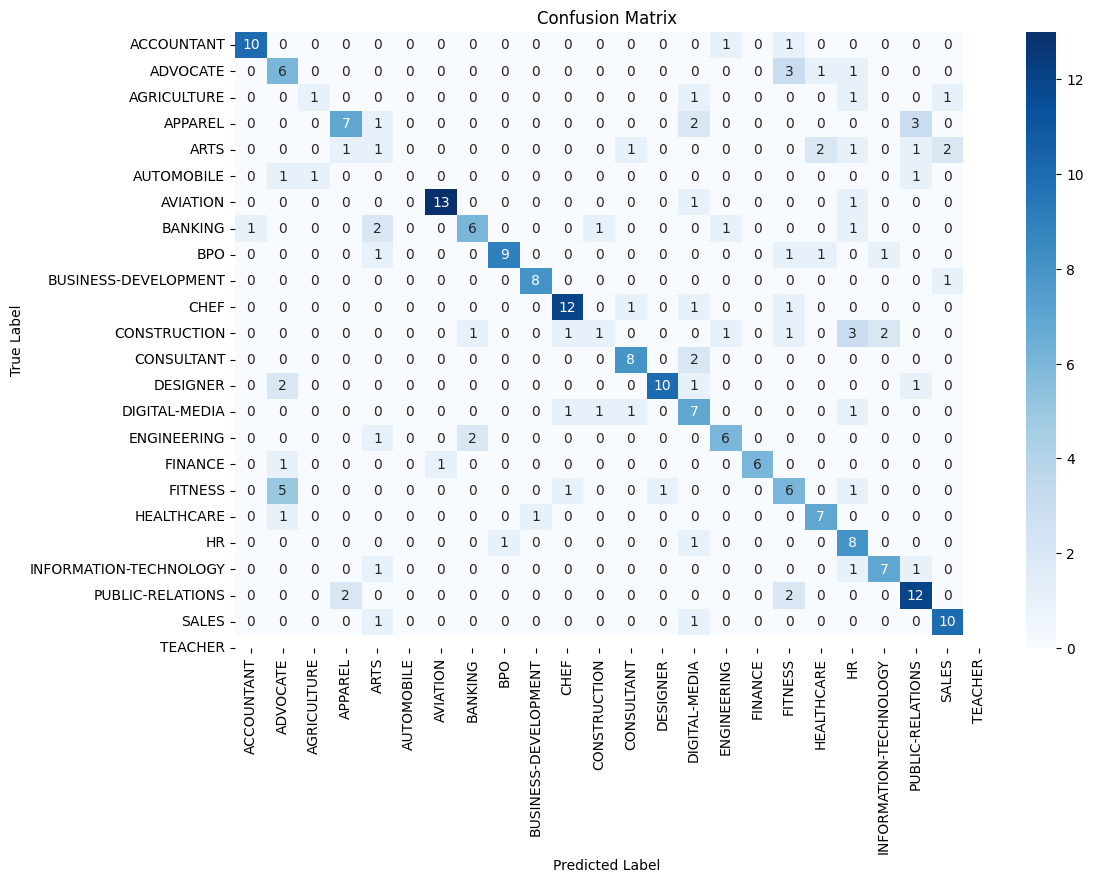

In [6]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_test, y_pred)
categories = list(encoding_corr.values())

plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=categories, yticklabels=categories)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [7]:

weighted_avg_and_overall_accuracy = mapping_report.iloc[-1].copy()
weighted_avg_and_overall_accuracy["overall_accuracy"] = mapping_report.iloc[-3]["precision"]
weighted_avg_and_overall_accuracy.drop(["support"], inplace=True)
weighted_avg_and_overall_accuracy.rename(index={
    "precision": "weighted precision",
    "recall": "weighted recall",
    "f1-score": "weighted f1-score"
}, inplace=True)

fig = px.bar(weighted_avg_and_overall_accuracy.reset_index(),
             x="index", y="weighted avg",
             title="Weighted Average and Overall Average",
             labels={"index": "Matrix", "weighted avg": "Score"},
             text_auto=True)
fig.show()